In [1]:
from openai import AsyncOpenAI
import asyncio
import numpy as np
import json
from itertools import combinations, chain
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
api_key = open("api_key_new.txt").read().strip()
client = AsyncOpenAI(api_key = api_key)

response = await client.embeddings.create(input=["Hello, world!"] ,model = "text-embedding-3-large")

In [2]:
async def get_embedding(text, model="text-embedding-3-large"):
    if not text:
        return []
    if type(text) != list:
        response = await client.embeddings.create(input=[text], model=model)
        return response.data[0].embedding
    response = await client.embeddings.create(input=text, model=model)
    return [r.embedding for r in response.data]

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def flatten_values(values):
    for value in values:
        if isinstance(value, list):
            for item in value:
                yield item
        else:
            yield value

In [3]:
DEGREE_ALIAS = {
    "highschool": ["high_school", "high school", "highschool", "high-school", "secondary school", "secondaryschool", "secondary-school"],
    "associate": ["associate", "associates", "associate's", "associates'", "associate bachelor", "associate bs"],
    "bs": ["bachelor", "bachelors", "bachelor's", "bachelors'", "undergraduate", "undergrad", "undergrads", "undergrad's", "undergrads'", "bs", "ba", "b.sc", "b.sc.", "bsc", "bachelor of science", "bachelor of arts", "b.a.","b.a"],
    "ma": ["master", "masters", "master's", "masters'", "graduate", "grad", "grads", "grad's", "grads'", "ms", "ma", "m.sc", "m.sc.", "msc", "master of science", "master of arts", "m.a.","m.a"],
    "phd": ["phd", "ph.d", "doctorate", "doctoral", "doctor", "doctor's", "doctorate of philosophy", "doctorate of philosophy", "doctor of philosophy"],
    "md": ["md", "m.d", "doctor of medicine", "doctorate of medicine"],
    "do" : ["do", "d.o", "doctor of osteopathic medicine", "doctorate of osteopathic medicine"],
    "jd": ["jd", "j.d", "juris doctor", "juris doctorate"],
    "pharmd": ["pharmd", "pharm.d", "doctor of pharmacy", "doctorate of pharmacy"],
    "mba": ["mba", "m.b.a", "master of business administration"],
    "dba": ["dba", "d.b.a", "doctor of business administration"],
}
potential_degrees = list(DEGREE_ALIAS.keys())
potential_degrees_embeddings = await asyncio.gather(*[get_embedding(potential) for potential in potential_degrees])

for key in DEGREE_ALIAS:
    DEGREE_ALIAS[key] = sorted(DEGREE_ALIAS[key], key = len, reverse = True)

In [48]:
def string_from_education(education):
    string = ""
    if not education:
        return "null"
    for i in education:
        i["education_id"] = i["education_school_linkedin_url"] = i['education_school_logo'] = ''
        string += " ".join(value for value in flatten_values(i.values()))
        string += "."
    return string

def strings_from_education(education):
    strings = []
    for i in education:
        i["education_id"] = i["education_school_linkedin_url"] = i['education_school_logo'] = ''
        strings.append(" ".join(value for value in flatten_values(i.values())))
    return strings

def degree_normalization(degree):
    if not degree:
        return " "
    
    degree = degree.lower()
    for key, values in DEGREE_ALIAS.items():
        if any(value in degree for value in values):
            return key

    return degree

# helper function to calculate the similarity between two education entries
def calc_school_similarity(target, similar):
    if target['education_school'] == '' or similar['education_school'] == '':
        return 1
    return np.dot(target['education_school_embedding'], similar['education_school_embedding'])

def calc_degree_similarity(target, similar):
    return np.dot(target['education_degree_embedding'], similar['education_degree_embedding'])

async def calc_major_similarity(target, similar):
    if target['education_major'] in similar['education_major'] or similar['education_major'] in target['education_major']:
        return 1
    target_major_info = [target['education_major'], target['education_description'], target['education_activities']]
    similar_major_info = [similar['education_major'], similar['education_description'], similar['education_activities']]
    target_major_string = ''
    similar_major_string = ''
    for t,s in zip(target_major_info, similar_major_info):
        if t != '' and s != '':
            target_major_string += t
            target_major_string += ' '
            similar_major_string += s
            similar_major_string += ' '
    if target_major_string == '':
        return 1
    return np.dot(await get_embedding(target_major_string), await get_embedding(similar_major_string))

def calc_time_similarity(target, similar):
    # initialize time similarity to 1 (and as for no all time stamps available)
    time_similarity = 1
    if target['education_startyear'] == '' or similar['education_startyear'] == '':
        return int(target['education_endyear'] == similar['education_endyear'])
    elif target['education_endyear'] == '' or similar['education_endyear'] == '':
        return int(target['education_startyear'] == similar['education_startyear'])

    # at this point we know that both startyear and endyear are available
    target_startyear = int(target['education_startyear'])
    target_endyear = int(target['education_endyear'])
    similar_startyear = int(similar['education_startyear'])
    similar_endyear = int(similar['education_endyear'])
    value = max(0, min(target_endyear, similar_endyear) - max(target_startyear, similar_startyear))
    target_duration = abs(target_endyear - target_startyear)
    similar_duration = abs(similar_endyear - similar_startyear)
    if target_duration == 0 and similar_duration == 0:
        time_similarity = int(target_startyear == similar_startyear)
    else:
        time_similarity = 2 * value / (target_duration + similar_duration)
    return time_similarity

# return a list of dictionaries of information (check variable result) for each education entry
async def get_weighted_embedding(education):
    results = []
    for e in education:
        # This will be the format of result
        result = {
            'education_embedding': 0, 
            'education_school_embedding': 0, 
            'education_degree_embedding': 0, 
            'education_major_embedding': 0, 
            'education_year_score': 0, 
            'education_string': '', 
            'education_school': '', 
            'education_degree': '', 
            'education_major': '', 
            'education_description': '',
            'education_activities': '',
            'education_startyear': '', 
            'education_endyear': ''
            }
        result['education_school'] = e['education_school']

        result['education_degree'] = e['education_degree_level'] if e['education_degree_level'] != "" else degree_normalization(e['education_degree'])

        result['education_major'] = e['education_major'] 
        result['education_description'] = e['education_description']
        result['education_activities'] = e['education_activities']
        result['education_startyear'] = e['education_startyear']
        result['education_endyear'] = e['education_endyear']
        result['education_string'] = string_from_education([e])
        result['education_school_embedding'] = await get_embedding(result['education_school'])
        result['education_degree_embedding'] = await get_embedding(result['education_degree'])
        result['education_major_embedding'] = await get_embedding(result['education_major'])
        result['education_embedding'] = await get_embedding(result['education_school'] + " " + result['education_degree'] + " " + result['education_major'])
        results.append(result)
    return results

async def calculate_similarity_weighted(target_education, similar_education):
    target_embedding, similar_embedding = await get_weighted_embedding(target_education), await get_weighted_embedding(similar_education)
    if not target_embedding or not similar_embedding:
        return 0
    
    target_similar_mapping = {}

    all_combinations = []
    for t in target_embedding:
        for s in similar_embedding:
            all_combinations.append((t, s)) # t,s are dictionaries
    
    combination_similarities = []
    for (t,s) in all_combinations:
        temp = (t, s, calc_school_similarity(t,s) * calc_degree_similarity(t,s) * await calc_major_similarity(t,s) * calc_time_similarity(t,s))

        combination_similarities.append(temp)
    
    while combination_similarities:
        (t_max, s_max, similarity) = max(combination_similarities, key=lambda x: x[2])

        target_similar_mapping[t_max['education_string']] = (s_max['education_string'], similarity)   
        combination_similarities = [(t, s, sim) for t, s, sim in combination_similarities if t != t_max and s != s_max]

        time_similarity = calc_time_similarity(t_max, s_max)
        school_similarity = calc_school_similarity(t_max, s_max)
        degree_similarity = calc_degree_similarity(t_max, s_max)
        major_similarity = await calc_major_similarity(t_max, s_max)
        num_match = int(school_similarity > 0.9) + int(degree_similarity > 0.9) + int(major_similarity > 0.9)
        print(num_match)
        
    
    return target_similar_mapping

In [49]:
data = []
with open('export_profiles.jsonl', 'r') as f:
    for line in f:
        data.append(json.loads(line))

print(data[0])

{'target': {'additional_info': {}, 'analytics': {'availability': 0, 'availability_reason': [0], 'business_administration_level': 'mba', 'compensation_base_ave': 84547, 'compensation_base_max': 109911, 'compensation_base_min': 59182, 'contact_quality': 'high', 'contact_ranking_tier': 2, 'current_company_info': {}, 'current_company_start_date': '2016-12-25 00:00:00', 'current_title_start_date': '2018-07-25 00:00:00', 'diversity_analytics': {}, 'education': 'bs', 'experience': '20+', 'focus': ['operations'], 'focus_score': {'operations': 0.99}, 'fulltime_years': 21.33150684931507, 'gender': 'male', 'has_contact': True, 'has_personal_email': True, 'healthcare': {}, 'industry': ['paper & forest products'], 'it_analytics': {}, 'norm_location': {'city': 'Stevens Point', 'continent': 'North America', 'country': 'United States', 'country_short': 'US', 'in_gdpr': False, 'latitude': 44.5235792, 'location_fmt': 'Stevens Point, Wisconsin, United States', 'location_value': 'Stevens Point, Wisconsin,

In [50]:
data2 = []
with open('data/export_profiles_v2.jsonl', 'r') as f:
    for line in f:
        data2.append(json.loads(line))

print(data2[0])

{'target': {'additional_info': {}, 'analytics': {'availability': 0, 'availability_reason': [0], 'business_administration_level': 'mba', 'compensation_base_ave': 84547, 'compensation_base_max': 109911, 'compensation_base_min': 59182, 'contact_quality': 'high', 'contact_ranking_tier': 1, 'current_company_info': {}, 'current_company_start_date': '2016-12-08 00:00:00', 'current_title_start_date': '2018-07-08 00:00:00', 'diversity_analytics': {}, 'education': 'bs', 'experience': '20+', 'focus': ['operations'], 'focus_score': {'operations': 0.99}, 'fulltime_years': 21.284931506849315, 'gender': 'male', 'has_contact': True, 'has_personal_email': True, 'healthcare': {}, 'industry': ['paper & forest products'], 'it_analytics': {}, 'norm_location': {'city': 'Stevens Point', 'continent': 'North America', 'country': 'United States', 'country_short': 'US', 'in_gdpr': False, 'latitude': 44.5235792, 'location_fmt': 'Stevens Point, Wisconsin, United States', 'location_value': 'Stevens Point, Wisconsin

In [51]:
async def process(data):
    flattened_data = [(i['target']['education'], j['education']) for i in data for j in i['similar'].values()]
    # print(len(flattened_data))
    flattened_result = await asyncio.gather(*[calculate_similarity_weighted(target, similar) for target, similar in flattened_data])

    index = 0
    result = []
    for i in data:
        sub_result = []
        for _ in i['similar'].values():
            # print(index)
            sub_result.append(flattened_result[index])
            index += 1
        result.append(sub_result)
    return result

In [52]:
async def process_with_rate_limit(data, batch_size = 3000//8, delay = 60):
    flattened_data = [(i['target']['education'], j['education']) for i in data for j in i['similar'].values()]
    # print(len(flattened_data))
    total_batches = math.ceil(len(flattened_data) / batch_size)
    flattened_result = []
    for batch_num in range(total_batches):
        start = batch_num * batch_size
        end = min((batch_num + 1) * batch_size, len(flattened_data))
        batch = flattened_data[start:end]
        flattened_result.extend(await asyncio.gather(*[calculate_similarity_weighted(target, similar) for target, similar in batch]))
        # print(len(flattened_result))
        await asyncio.sleep(delay)

    index = 0
    result = []
    for i in data:
        sub_result = []
        for _ in i['similar'].values():
            # print(index)
            sub_result.append(flattened_result[index])
            index += 1
        result.append(sub_result)
    return result

### The following are some testing results which may be helpful if my code does not make much sense.

In [9]:
target_similar_score_list = []

In [31]:
target_similar_score_list = []
await process_with_rate_limit(data[:200])
await process_with_rate_limit(data[200:400])
await process_with_rate_limit(data[400:600])
await process_with_rate_limit(data[600:800])

3
2
1
3
3
2
3
3
3
3
3
3
3
3
3
3
2
3
2
3
3
3
3
3
2
3
3
1
1
2
2
1
2
3
3
3
3
2
2
2
1
3
1
2
3
2
2
2
1
2
1
1
1
2
2
1
2
2
1
3
3
1
3
3
1
3
1
3
2
1
3
3
2
3
2
2
3
2
1
1
3
3
1
3
2
0
1
2
2
0
3
2
3
3
3
3
2
0
1
3
3
3
3
2
3
3
2
1
3
3
2
3
1
1
3
2
2
3
3
2
3
2
1
2
2
2
2
1
3
3
3
3
3
3
3
2
2
2
1
2
3
2
3
3
2
3
2
1
2
3
3
3
1
3
3
1
3
2
3
3
2
2
3
2
3
1
2
1
1
1
3
2
0
1
3
3
3
2
3
1
0
2
1
1
1
0
1
0
3
2
3
1
3
3
3
2
2
3
1
1
1
0
3
1
2
2
1
2
1
1
2
2
2
1
1
1
2
2
2
1
2
2
1
1
3
3
3
3
1
2
2
1
3
3
3
3
3
3
3
2
3
3
3
0
0
2
2
1
3
0
1
1
1
1
2
2
3
1
3
3
3
2
1
2
1
0
1
1
1
1
1
2
3
3
3
3
2
3
3
3
3
2
1
2
2
1
0
2
3
3
0
1
2
0
1
2
2
3
1
1
3
2
2
1
1
1
1
1
2
1
2
1
0
1
1
1
0
2
1
0
0
0
1
1
2
2
1
3
0
2
0
1
0
0
1
2
1
0
0
2
0
0
2
2
0
1
2
2
1
2
0
3
1
0
0
3
3
3
3
3
3
3
3
3
1
3
2
2
2
3
3
3
3
3
3
1
2
3
1
2
2
3
2
2
3
1
2
2
1
2
3
3
2
2
2
2
2
3
1
2
2
2
2
2
3
1
2
2
3
2
1
2
2
2
1
2
3
3
3
0
3
1
2
1
3
3
0
2
3
2
1
3
2
1
2
0
2
1
3
3
2
2
2
3
1
2
2
2
2
1
1
1
2
3
3
1
2
1
2
2
1
2
3
3
1
1
1
1
3
3
2
1
0
1
1
1
1
2
1
2
2
0
2
1
2
1
2
2
2
1
1
2
1
3
3
2
2
2
2
2


[[{" Master's ms  2021    Concordia University   .": (" Master's degree ms  2021    Concordia University   2019.",
    np.float64(0.9999990915002462))}],
 [{' Master of Computer Science (MSc) ms Courses:\nAgile Development.\nTheory of Database.\nModern Concepts of Operating Systems.\nNetwork & Distributed Programming.\nVerification & Validation.\nSystems Requirements Engineering.\n 2015   Software Engineering University of Khartoum   2014 computer science and engineering.': ("Engineer's Week Master of Science (MSc) ms  2015   Software Engineering University of Khartoum   2014 computer science and engineering.",
    np.float64(0.9999988601350724)),
   ' Bachelor of Science (BSc) bs  2010   Electrical and Electronics Engineering/ Software Engineering University of Khartoum   2005 electrical engineering computer science and engineering electronic engineering electrical and electronics engineering.': (' Bachelor of Science (BSc) bs  2010   Electrical and Electronics Engineering/ Software E

In [37]:
len([ x for x in target_similar_score_list if x >= 2.5]) / len(target_similar_score_list)

0.7865085248332098

In [33]:
np.mean(target_similar_score_list)

np.float64(3.153898973440306)

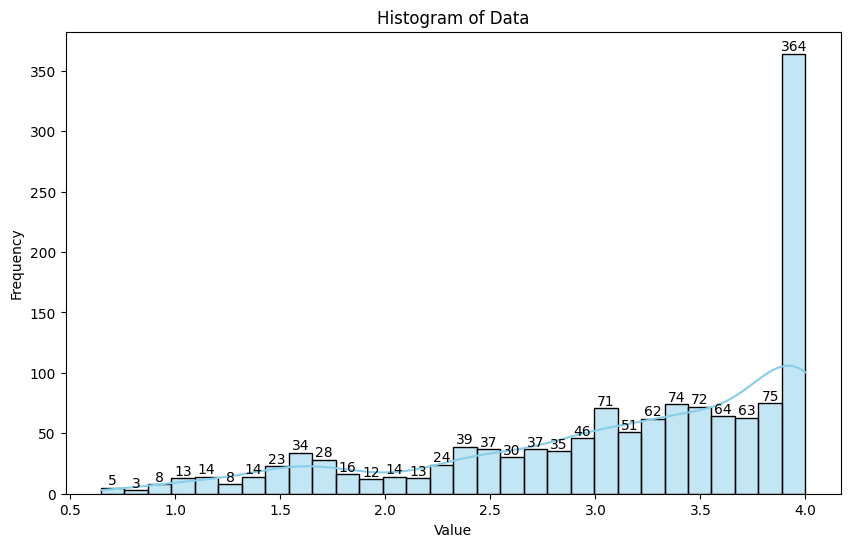

In [34]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(target_similar_score_list, bins=30, kde=True, color='skyblue', edgecolor='black')
ax.bar_label(ax.containers[0])
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.show()

In [10]:
async def process_combination_data_with_rate_limit(data, batch_size = 300, delay = 60):
    combination_data = []
    for i in range(len(data)):
        for j in range(i, len(data)):
            combination_data.append((data[i]['target']['education'], data[j]['target']['education']))
    total_batches = math.ceil(len(combination_data) / batch_size)
    flattened_results = []
    for batch_num in range(total_batches):
        start = batch_num * batch_size
        end = min((batch_num + 1) * batch_size, len(combination_data))
        batch = combination_data[start:end]
        flattened_results.extend(await asyncio.gather(*[calculate_similarity_weighted(target, potential) for target, potential in batch]))
        await asyncio.sleep(delay)
    
    return flattened_results

In [34]:
target_similar_score_list = []
result = []
for i in range(10):
    result.extend(await process_combination_data_with_rate_limit(data[20*i:20*(i+1)]))

3
3
3
1
1
1
2
2
0
2
2
1
1
0
3
3
1
1
1
2
1
3
3
0
1
0
1
1
1
1
1
1
2
1
0
1
3
3
3
0
0
0
2
1
0
1
1
0
1
3
3
1
0
1
0
0
3
3
1
0
3
3
1
1
0
0
1
2
1
3
3
0
2
3
3
0
0
1
1
2
1
1
1
0
1
1
2
1
0
2
0
1
1
0
1
1
1
3
3
3
1
1
0
1
1
1
1
1
0
1
1
0
1
1
0
0
2
0
2
0
0
1
2
1
1
1
2
1
0
0
0
0
1
0
1
0
1
2
1
0
2
0
1
1
1
1
0
3
3
3
1
0
1
1
0
1
1
1
1
1
0
0
0
1
0
2
0
0
3
3
3
1
0
1
1
1
1
2
1
0
1
1
1
1
0
1
0
1
1
0
1
1
1
0
1
0
1
0
1
0
1
0
1
1
1
0
0
1
1
0
1
0
1
1
2
1
1
0
0
0
0
1
1
1
0
0
3
3
3
0
0
0
0
1
1
0
1
0
0
0
1
1
0
1
1
0
0
0
3
3
3
3
3
3
0
0
0
1
0
1
1
1
0
1
1
2
0
0
0
1
1
0
0
0
0
1
0
0
1
1
3
3
3
1
0
0
0
1
2
1
0
1
1
1
1
0
1
0
0
0
0
0
0
1
0
1
0
0
0
0
1
0
1
0
1
0
1
0
0
0
0
1
0
0
1
0
0
1
0
0
1
0
0
0
1
0
0
0
1
0
0
1
0
0
0
1
0
2
1
0
2
0
0
0
0
0
0
0
2
0
0
0
0
0
0
1
0
0
3
3
3
3
3
3
3
1
1
3
3
3
1
2
1
3
3
3
1
0
0
2
2
1
0
1
1
0
1
0
1
1
3
3
0
3
3
3
1
0
2
0
1
1
1
1
1
0
1
3
1
1
1
1
1
2
2
0
0
1
0
1
2
1
2
2
0
2
0
1
0
1
2
1
0
1
1
1
0
1
1
0
1
1
1
1
2
0
0
1
1
1
0
3
3
3
3
0
0
0
1
1
2
1
0
0
2
1
1
0
1
0
0
0
2
3
3
1
1
1
1
0
0
2
1
0
0
0
0
0
0
2


In [43]:
temp = [ x for x in target_similar_score_list if abs(x-4) >= 0.01]

In [44]:
len(target_similar_score_list) - len(temp)

425

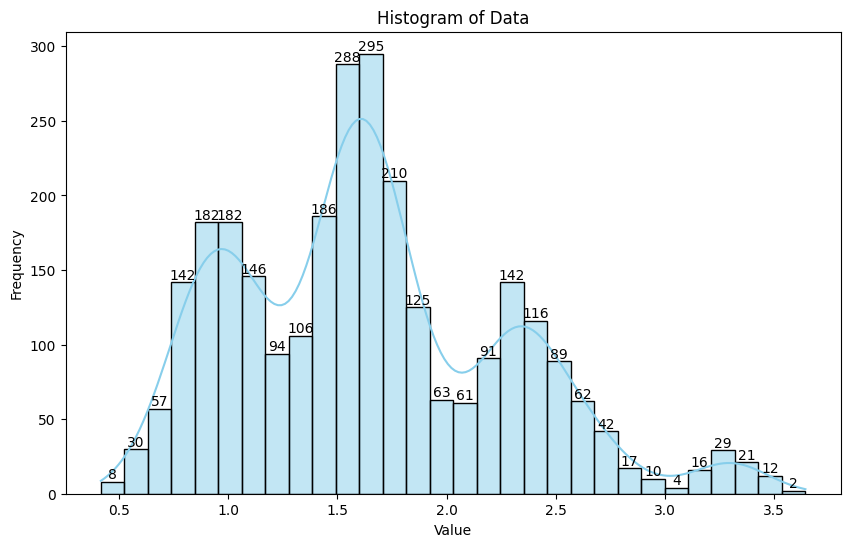

In [45]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(temp, bins=30, kde=True, color='skyblue', edgecolor='black')
ax.bar_label(ax.containers[0])
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.show()